### Getting accurate monthly series for campaign finance

### What's the issue? Why is this so hard?
The problem in trying to show accurate monthly campaign finance total fundraising, of the sort used in visualizations like the NYT's [2012 Money Race](http://elections.nytimes.com/2012/campaign-finance) is the simple one that campaigns do not actually report data monthly. This was the [presidential principal campaign committee reporting schedule](http://www.fec.gov/info/report_dates_2012.shtml#monthly) for the 2012 election. You can see that campaigns reported quarterly in 2011, and only began monthly reports in 2012. In addition, because the election is in November, reporting deadlines mean that the final three periods are not quite monthly and all have highly skewed coverage periods which need to be adjusted for as well.

### But the FEC has all this itemized data available with transaction dates - why can't we use that?
The itemized data is only a small subset of the overal data. So in the 2012 election cycle, for instance, Obama for America raised 738.5 million, of which 315 million came from individal donors that gave more than 200 bucks, and 234 million came from individual donors that gave less than 200 bucks (the rest came from authorized committees and a few other places). But donations less than 200 aren't required to be itemized, so they don't show up in the itemized dataset. In addition, the 315 million number includes donations from those who gave over 200 in total, but in a series of smaller donations. These also don't show up in the FEC's itemized data, so the itemized data only include about 200 mm - a small fraction of the total. If we looked at these, we would think that Romney had massively outraised Obama - but in fact the opposite was true.

### So what do we do?

The FEC Form 3P data represents the accurate totals, but is a mixture of quarterly and monthly data. The itemized data is only a fraction of the total, but we have dates for every single itemized contribution. So we can use the itemized data as a proxy for the overal time distribution of fundraising, and use the amount that each month represents out of the quarterly totals to prorate the Form 3P data where that data is quarterly.

### What data sources do we use
Getting the Form 3P data is harder than it would seem - the FEC website lets you download spreadsheets with totals, but it's a highly manual process - no persistent links. Better is to use the new beta FEC API, which makes it very easy to get the Form 3P data.

For the itemized data, the API isn't suitable - while the itemized data is available, the endpoints that give aggregates don't give us enough detail or control, while the endpoints that give true itemized data don't at the moment let you filter or agregate to get to a point where the data size is limited - and so as a result there are huge rate limiting problems going down this route. Much better to use the csv files the FEC makes available.


In [1]:
import requests, json, zipfile, StringIO, urllib2, os
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

import pandas as pd
import dateutil.parser

from ipywidgets import widgets
from IPython.display import display, clear_output

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Populating the interactive namespace from numpy and matplotlib


### Setting up to get Form 3P data through the FEC Beta API
While there is a [python wrapper](https://github.com/jeremyjbowers/pyopenfec) available, it isn't well maintained, and breaking changes to the API have already caused problems. Since what we want is super simple to get, much better to just use requests and hit the REST API endpoints directly. The functions below are set up to do that.

Anyone who wants to get an excel spreadsheet to look at for comparison can go to http://www.fec.gov/data/CommitteeSummary.do?format=html&election_yr=2012 and enter in a campaign code and click through and eventually get one.

In [2]:
BASE_URL = 'https://api.open.fec.gov/v1'
envVars = %env
API_KEY = envVars['OPENFEC_API_KEY']

In [3]:
def all_results(endpoint, params):
    params['api_key'] = API_KEY
    url = BASE_URL+endpoint
    r = requests.get(url, params=params)
    initial_data = r.json()
    num_pages = initial_data['pagination']['pages']
    num_records = initial_data['pagination']['count']
    current_page = initial_data['pagination']['page']
    for record in initial_data['results']:
        yield record

    while current_page < num_pages:
        current_page += 1
        params['page']=current_page
        data = requests.get(url, params=params).json()
        for record in data['results']:
            yield record

def count_results(endpoint, params):
    params['api_key'] = API_KEY
    url = BASE_URL+endpoint
    data = requests.get(url, params=params).json()
    return data['pagination']['count']

In [8]:
with open('../W209 Viz Drafts/data/candidates.json', 'r') as f:
    candidate_data = json.load(f)
candidate_data = { year: candidate_data[year] for year in candidate_data.keys() if int(year) >= 2012 }

In [9]:
def form3totals(committee_id, cycle):
    q = {
        'cycle':cycle,
        'per_page':100,
        'is_amended':False,
    }
    data = []
    for r in all_results('/committee/'+committee_id+'/reports/', q):
        data.append({
                'Report Year': r["report_year"],
                'Report Type': r["report_type"],
                'Report Period': str(r["report_year"])+'-'+r["report_type"],
                'Coverage Start Date': dateutil.parser.parse(r["coverage_start_date"]).date(),
                'Coverage End Date': dateutil.parser.parse(r["coverage_end_date"]).date(),
                'Itemized Individual Contributions': r["individual_itemized_contributions_period"],
                'Unitemized Individual Contributions': r["individual_unitemized_contributions_period"],
                'Total Individual Contributions': r["total_individual_contributions_period"],
                'Party Committees Contributions': r["political_party_committee_contributions_period"],
                'Other Committees Contributions': r["other_political_committee_contributions_period"],
                'Candidate Contributions': r["candidate_contribution_period"],
                'TOTAL CONTRIBUTIONS': r["total_contributions_period"],
                'Transfers from Affilliated Committees': r["transfers_from_affiliated_committee_period"],
                'Loans': r["total_loans_received_period"],
                'Offsets': r["total_offsets_to_operating_expenditures_period"],
                'Total Receipts': r["total_receipts_period"],
                'Operating Expenditures': r["operating_expenditures_period"],
                'TOTAL DISBURSEMENTS': r["total_disbursements_period"],
                'Beginning Cash On Hand': r["cash_on_hand_beginning_period"],
                'Ending Cash On Hand': r["cash_on_hand_end_period"],
            })
    columns = [
        'Report Period','Report Year','Report Type','Coverage Start Date','Coverage End Date','Itemized Individual Contributions',
        'Unitemized Individual Contributions','Total Individual Contributions','Party Committees Contributions',
        'Other Committees Contributions','Candidate Contributions','TOTAL CONTRIBUTIONS',
        'Transfers from Affilliated Committees','Loans','Offsets','Total Receipts',
        'Beginning Cash On Hand','Ending Cash On Hand']
    df = pd.DataFrame(data, columns=columns)

    
    df.set_index('Report Period', inplace=True)
    return df.sort('Coverage Start Date')

### Getting the itemized data in bulk in csv form from the FEC website
The below gets all of the available itemized data from the FEC - just uncomment the function call to run for a specified year.

In [10]:
# To download all schedule detail csv files for a particular year

schedule_dict = {'Committees': {'abbrev':'cm', 'filename':'cm'},
            'Candidates': {'abbrev':'cn', 'filename':'cn'},
            'Candidate Committee Linkage': {'abbrev':'ccl', 'filename':'ccl'},
            'Committee to Committee Trans': {'abbrev':'oth', 'filename':'itoth'},
            'Contributions by Committees': {'abbrev':'pas2', 'filename':'itpas2'},
            'Contributions by Individuals': {'abbrev':'indiv', 'filename':'itcont'},
            'Operating Expenditures': {'abbrev':'oppexp', 'filename':'oppexp'}
             }
header_url_base = 'http://www.fec.gov/finance/disclosure/metadata/%s_header_file.csv'
data_url_base = 'ftp://ftp.fec.gov/FEC/20%d/%s%d.zip'


def get_schedule_data(year, schedule_dict):
    yearlasttwo = int(str(year)[2:])
    for f in schedule_dict.values():
        pathname = '%s_%s.csv' % (year, f['abbrev'])
        if not (os.path.isfile(pathname) and os.path.getsize(pathname) > 0):
            print " downloading %s..." % pathname,
            r = requests.get(header_url_base % f['abbrev'])
            f['headers'] = r.content.strip().split(',')
            d = urllib2.urlopen(data_url_base % (yearlasttwo, f['abbrev'], yearlasttwo))
            z = zipfile.ZipFile(StringIO.StringIO(d.read()))
            data = pd.read_csv(z.open('%s.txt' % f['filename']), sep='|', header=None, names=f['headers'], index_col=False,
                        low_memory=False)
            data.to_csv(pathname)
            print "done."
        else:
            print " skipping %s." % pathname

for cycle in sorted(candidate_data.keys()):
    print "downloading data for", cycle
    get_schedule_data(cycle, schedule_dict)


downloading data for 2012
 skipping 2012_cm.csv.
 skipping 2012_ccl.csv.
 skipping 2012_oppexp.csv.
 skipping 2012_indiv.csv.
 skipping 2012_cn.csv.
 skipping 2012_pas2.csv.
 skipping 2012_oth.csv.
downloading data for 2016
 skipping 2016_cm.csv.
 skipping 2016_ccl.csv.
 skipping 2016_oppexp.csv.
 skipping 2016_indiv.csv.
 skipping 2016_cn.csv.
 skipping 2016_pas2.csv.
 skipping 2016_oth.csv.


### Processing the Individual Contributions data
This just dumps the small number of cases where we don't have any dates for contributions, and then adds month year and quarter indices to make later manipulation easy, before saving the csv file back down.

In [19]:
# Process the individual contributions csv
def process_indiv(year):
    pathname_in = '%s_indiv.csv' % year
    pathname_out = '%s_indiv_p1.csv' % year
    if os.path.isfile(pathname_in) and os.path.getsize(pathname_in) > 0:
        if not (os.path.isfile(pathname_out) and os.path.getsize(pathname_out) > 0):
            print " processing %s into %s..." % (pathname_in, pathname_out),
            indiv = pd.read_csv(pathname_in, low_memory=False)
            indiv = indiv[indiv['TRANSACTION_DT'].notnull()].copy()  # if there isn't a date, no use to us
            indiv['TRANSACTION_DT'] = indiv['TRANSACTION_DT'].astype(int).map("{:0>8d}".format)
            indiv['DATE'] = pd.to_datetime(indiv['TRANSACTION_DT'],format='%m%d%Y')
            indiv['MONTH'] = pd.DatetimeIndex(indiv['DATE']).month
            indiv['YEAR'] = pd.DatetimeIndex(indiv['DATE']).year
            indiv['QUARTER'] = pd.DatetimeIndex(indiv['DATE']).quarter
            indiv.to_csv(pathname_out)
            print "done."
        else:
            print "skipping %s." % pathname_out
    else:
        print 'ERROR: %s not found' % pathname_in

for cycle in sorted(candidate_data):
    process_indiv(cycle)

 processing 2012_indiv.csv into 2012_indiv_p1.csv... done.
 processing 2016_indiv.csv into 2016_indiv_p1.csv... done.


### Load the individual contribution data into memory
That makes it much faster to work with from that point on

In [20]:
indivs = pd.DataFrame()
for cycle in sorted(candidate_data.keys()):
    print "reading processed indiv for", cycle
    indivs = indivs.append(pd.read_csv(cycle +'_indiv_p1.csv', low_memory=False))

reading processed indiv for 2012
reading processed indiv for 2016


### Creating monthly pro-rating coefficients from the individual contribution data
The below function returns a series of coefficients, indexed by year, quarter and month, to be used in prorating quarterly data to monthly. At the moment it is set up to work with the itemized individual contribution data; we probably need to generalize it so it can also work on the spending side to work with the itemized spending data.

The f3Monthly function then takes a form F3 period series, and a monthly pro-rating coefficient series as inputs, applies the pro-rating methodology, and returns a monthly series as output.

In [24]:
def monthly_coeffs(committee_id, indivs):
    indiv = indivs[indivs['CMTE_ID']==committee_id].copy()
    i = indiv.groupby(by=['YEAR', 'QUARTER', 'MONTH']).sum()['TRANSACTION_AMT']
    monthly = pd.DataFrame({
        'Monthly Contributions': i,
        'Monthly Totals': i.groupby(level=['YEAR', 'QUARTER']).transform(sum)
    })
    monthly['Pro Rating Coeffs'] = monthly['Monthly Contributions']/monthly['Monthly Totals']

    return monthly['Pro Rating Coeffs']

In [42]:
def f3Monthly(f3,coeffs,cycle):
    
    def f3_extract(label, default=0):
        return f3.loc[label] if label in f3.index else default
    
    years = coeffs.index.levels[0]
    quarters = coeffs.index.levels[1]
    months = coeffs.index.levels[2]
    monthly_data = coeffs.copy()
    
    monthly_data.name = 'Monthly Data'
    yq = ''
    #for i, y in enumerate(years):
    for y in years:
        if y != cycle:
            # The year before the election, all data is quarterly, so we need to use our
            # Coefficients from the itemized data to prorate across the months
            for q in quarters:
                if q < 4:
                    yq = str(y)+'-Q'+str(q)  # First three quarters of F3 data follow this pattern
                else:
                    yq = str(y)+'-YE'  # Last quarter is Year End, just to keep you on your toes
                coef = coeffs[y][q] if y < len(coeffs) and q < len(coeffs[y]) else 0
                monthly_data[y][q] = f3_extract(yq) * coef
        else:
            for m in months:
                # The first 3 quarters of the election year we have monthly data for
                q = ((m-1)/3)+1  # Convert month to quarter
                if m < 10:
                    monthly_data[y][q][m] = f3_extract(str(y)+'-M'+str(m+1))
                else:
                    # Because October/November filing are split by random pre/post election filing deadlie
                    # We need to agregate them to the quarter level and then use the itemized to prorate
                    final_quarter = (f3_extract(str(y)+'-12G') +
                                     f3_extract(str(y)+'-30G') +
                                     f3_extract(str(y)+'-YE'))
                    monthly_data[y][q] = final_quarter * coeffs[y][q]
                    
    return monthly_data

## Bringing it all together interactively, so we can look at different candidates
At the moment, this works for major candidates who have FEC reported data for all periods, but not for those who don't - if you try selecting someone other than Obama or Romney, you will get a traceback. Clearly there is further work to do in generalizing the functions above to make sure they work for everyone. That sort of testing is the reason I decided to put in the interactive dropdowns - so we can test things easily and make sure the data works, before we have a working front end done.

In [43]:
def select_candidate(candidate):
    global f3
    global coeffs
    cycle = cycleOptions.value
    party = partyOptions.value
    candidate_dict = [c for c in candidate_data[cycle][party] if c['short_name'] == candidate][0]
    candidate_id = candidate_dict['candidate_ids'][0] if len(candidate_dict['candidate_ids']) > 0 else '<NA>'
    committee_id = candidate_dict['committees'][0]['committee_id']
    cand_id.value = "<strong>Candidate ID: </strong>%s<br><strong>Committee ID: </strong>%s"%(candidate_id, committee_id)
    f3 = form3totals(committee_id, cycle)

    coeffs = monthly_coeffs(committee_id, indivs)
    monthly = f3Monthly(f3['Total Receipts'], coeffs, int(cycle))
    
    ax=monthly.plot(kind='bar')
    ax.yaxis.set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )
    plt.draw()

def select_party(party):
    candidateOptions.options = [candidate['short_name'] for candidate in candidate_data[cycleOptions.value][party]]

def select_cycle(cycle):
    partyOptions.options = candidate_data[cycleOptions.value].keys()

/Users/tkunicki/.virtualenvs/w209/lib/python2.7/site-packages/ipykernel/__main__.py:41: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


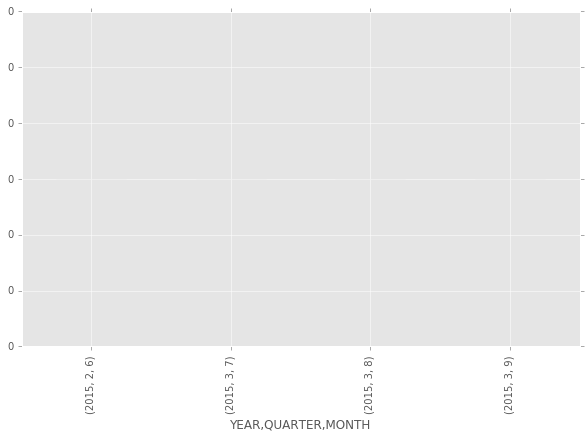

In [44]:
cycleOptions = widgets.Dropdown(options=candidate_data.keys())
initCycle = cycleOptions.value    

partyOptions = widgets.Dropdown(options=candidate_data[initCycle].keys())
initParty = partyOptions.value

candidateOptions = widgets.Dropdown(options=[candidate['short_name'] for candidate in candidate_data[cycleOptions.value][initParty]])

c = widgets.interactive(select_candidate, candidate=candidateOptions)
p = widgets.interactive(select_party, party=partyOptions)
y = widgets.interactive(select_cycle, cycle=cycleOptions)

cand_id = widgets.HTML()

display(y)
display(p)
display(c)
display(cand_id)

## What's next when it comes to data getting and cleaning?
OK - having got this far, there's a whole bunch more stuff to do:
* Make the above work for all candidates
* Specify Super-PACs directly associated with individual candidates (probably in candidates.json) and make sure we are pulling data for all of those
* Think about how we handle DNC/RNC - if we were just looking at presidential and not primary candidates, that would be easy because we could just add them to the candidates like the NYT's [2012 Money Race](http://elections.nytimes.com/2012/campaign-finance) does. Maybe we can still do that, and just not include them for 2015 because not relevant yet??
* Get the above working for all candidates, and for directly affiliated SuperPACs and DNC/RNC
* Where a candidate has more than one committe (ie Michelle Bachman), make sure we can handle that

Expanding beyond just candidate campaign committees and directly associated SuperPACs and DNC/RNC, the next step is to look at the independent expenditure data (probably easiest to use pas2.csv from the itemized data csvs) and get the list of top spenders for and against each candidate, probably using [this dictionary of transaction type codes](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryTransactionTypeCodes.shtml). Could just list them and show/graph amonts, or we could try to create a sort of [network visualization of SuperPAC contributions](http://www.brightpointinc.com/political_influence/)

Then we also need to look at further use we want to make of the itemized data - there is a lot of stuff we can do with it (well suited to small multiples in particular). If we are going to be doing timeseries stuff, we want to use the itemized csv files. But if we are going to do total aggregate stuff, the FEC beta API provides really nice easy API endpoints for that that give us exactly the data we need.

Then we may need to bring this all together in a nice REST API, unless we decide that we can dump everything we actually need to csv...

In [ ]:
!head candidates.json

In [ ]:
ls